# Deep Learning Portfolio 1

|Name|Github|Kaggle|
|----|------|------|
|Mohamed Belaachir|mobelaachir|Mo Belaachir|
|Jayden Debi-Tewari|Jaydendt1|jaydendt123|
|Quincy Soerohardjo|quincysoerohardjo2002|Quincy Soerohardjo|
|Michal Reszka-Gniecki|Ckires|...|

## Table of Contents
- [Data Overview](#data-overview)
- [Exploratory Data Analysis](#exploratory-data-analysis)
    - [Visualiseren](#visualiseren)
- [Feature Engineering](#feature-engineering)
    - [Analysis](#analysis)
- [Modeling](#modeling)
    - [Fully-connected neuraal netwerk](#Model1)
    - [Convolutioneel neuraal netwerk from scratch](#Model2)
    - [Transfer learning](#Model3)
    - [Multimodaal mode](#Model4)
- [Results](#results)
    - [Overview](#overview)
    - [Scores](#scores)
- [Conclusion & Advice](#conclusion--advice)
- [Sources](#sources)

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import os
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import cv2
from google.colab.patches import cv2_imshow
from google.colab import drive
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers


## Data Overview

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


## Data importeren

In [3]:
train_numeriek_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Portfolio 1 Datasets/train.csv')
test_numeriek_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Portfolio 1 Datasets/test.csv')

In [4]:
img_train_directory = "/content/drive/MyDrive/Colab Notebooks/Portfolio 1 Datasets/Train"
img_test_directory = "/content/drive/MyDrive/Colab Notebooks/Portfolio 1 Datasets/Test"

## Exploratory Data Analysis

### EDA voor de afbeeldingen


Alle JPEG-afbeeldingen uit de opgegeven map Train en Test worden geladen en opgeslagen in twee lijsten.

In [5]:
image_paths = tf.io.gfile.glob(img_train_directory + '/*.jpg')
train_images = []
for path in image_paths:
    image_raw = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image_raw)
    train_images.append(image)

In [6]:
image_paths_test = tf.io.gfile.glob(img_test_directory + '/*.jpg')
test_images = []
for path in image_paths_test:
    image_raw = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image_raw)
    test_images.append(image)

Het aantal geladen afbeeldingen in de datasets train_images en test_images wordt weergegeven.

In [7]:
print(f"Aantal geladen afbeeldingen: {len(train_images)}")
print(f"Aantal geladen afbeeldingen: {len(test_images)}")


Aantal geladen afbeeldingen: 500
Aantal geladen afbeeldingen: 35


De vormen (shapes) van de afbeeldingen in de train_images dataset worden geanalyseerd, waarbij alle unieke afbeeldingsformaten worden weergegeven.

In [8]:
image_shapes = [image.shape for image in train_images]
# Om alle unieke shapes te zien:
print(f"Unique shapes : {set(tuple(shape) for shape in image_shapes)}")

Unique shapes : {(1024, 1024, 3)}


De vorm (shape) van de eerste afbeelding in de train_images dataset wordt hiermee weergegeven.

In [9]:
print(f"Image shape: {train_images[0].shape}") # geeft de shape van de eerste image (H, W, C)
# het laatste getal in de shape is het aantal kleurkanalen

Image shape: (1024, 1024, 3)


## Voorbeeld van trainings- en testafbeeldingen

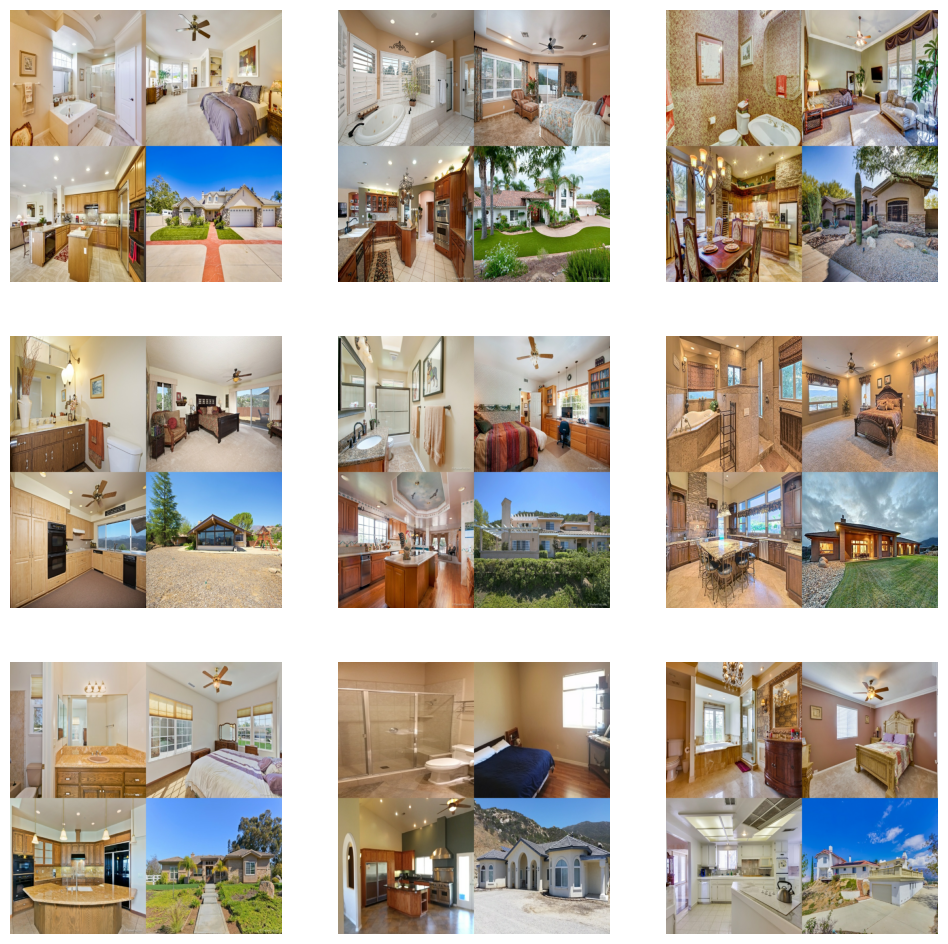

In [10]:
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_images[i].numpy())
    plt.axis("off")
plt.show()

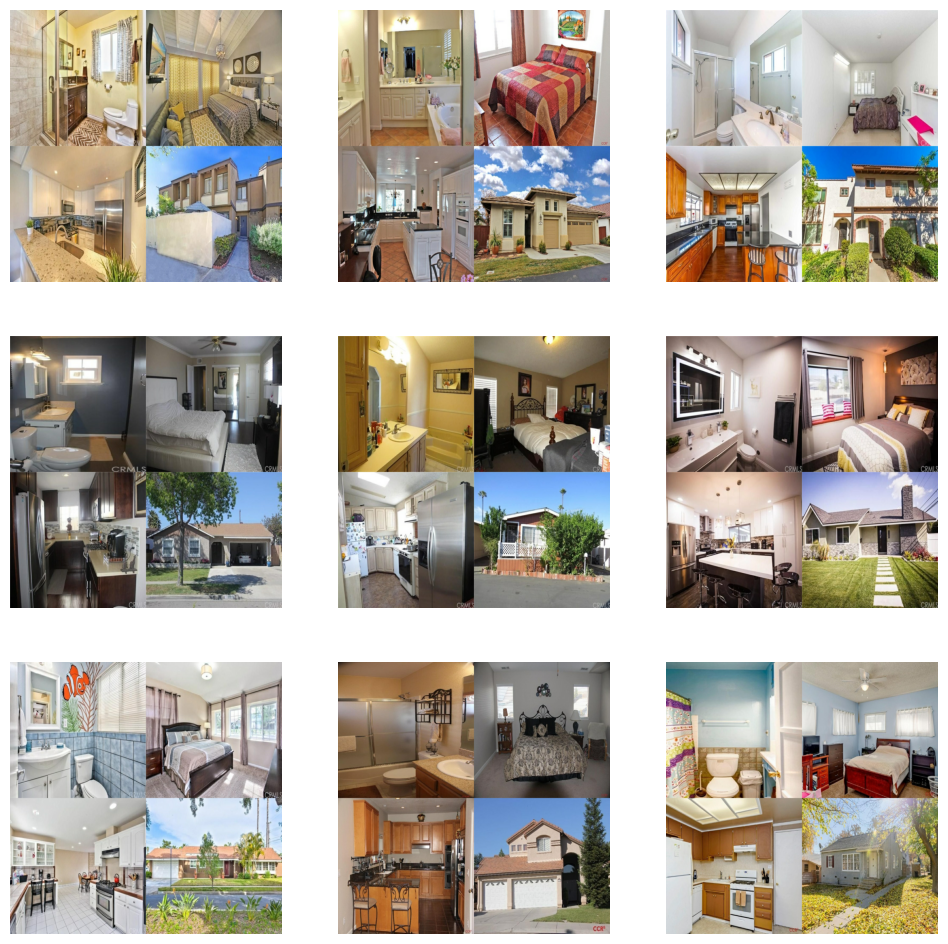

In [11]:
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i].numpy())
    plt.axis("off")
plt.show()

De grafiek toont de verdeling van pixelwaarden voor de kleuren rood, groen en blauw in de afbeeldingen.

Mean pixel values: [142.74492561 133.55400624 119.70312065]


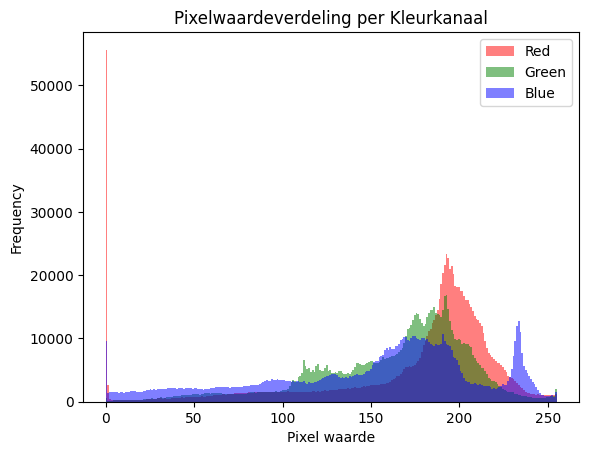

In [12]:
# Converteer images naar NumPy arrays
image_arrays = [image.numpy() for image in train_images]

# Bereken de gemiddelde pixelwaarde per kanaal
mean_pixel_values = np.mean(image_arrays, axis=(0, 1, 2))
print(f"Mean pixel values: {mean_pixel_values}")

# Plot histogrammen van pixelwaarden per kanaal
plt.hist(image_arrays[0][:, :, 0].flatten(), bins=256, color='red', alpha=0.5, label='Red')
plt.hist(image_arrays[0][:, :, 1].flatten(), bins=256, color='green', alpha=0.5, label='Green')
plt.hist(image_arrays[0][:, :, 2].flatten(), bins=256, color='blue', alpha=0.5, label='Blue')
plt.legend()
plt.title('Pixelwaardeverdeling per Kleurkanaal')
plt.xlabel('Pixel waarde')
plt.ylabel('Frequency')
plt.show()

De x-as vertegenwoordigt de pixelwaarden, die variëren van 0 tot 250, en de y-as geeft het aantal pixels weer voor elke waarde.

Uit de grafiek kunnen we afleiden hoe de intensiteit van elke kleur is verdeeld over de afbeelding. Als een bepaalde kleur een hogere piek heeft bij specifieke pixelwaarden, betekent dit dat die kleurintensiteit vaker voorkomt in de afbeeldingen.

De rode piek is het hoogst, gevolgd door groen en daarna blauw. Dit kan helpen om de kleurbalans en de algemene toon van de afbeelding te begrijpen. Een dominante rode piek kan wijzen op een warmere kleurtemperatuur in de afbeelding
.

### EDA voor tabel data

In [13]:
display(train_numeriek_df.head())
display(test_numeriek_df.head())

House ID  Bedrooms  Bathrooms  Area  Latitude  Longitude   Price
0         1         4        4.0  4053   33.6968  -111.8892  869500
1         2         4        3.0  3343   34.8280  -119.0349  865200
2         3         3        4.0  3923   33.7669  -111.9182  889000
3         4         5        5.0  4022   33.7752  -111.7791  910000
4         5         3        4.0  4116   33.7669  -111.9182  971226

House ID  Bedrooms  Bathrooms  Area  Latitude  Longitude
0       501         3        2.0  2330   35.6406  -120.7003
1       502         3        2.5  1339   35.6406  -120.7003
2       503         3        2.0  1472   35.6406  -120.7003
3       504         4        4.0  2681   35.6406  -120.7003
4       505         3        2.5  1935   33.8085  -117.9228

###Datatype

In [14]:
train_numeriek_df.info()
test_numeriek_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   House ID   500 non-null    int64  
 1   Bedrooms   500 non-null    int64  
 2   Bathrooms  500 non-null    float64
 3   Area       500 non-null    int64  
 4   Latitude   500 non-null    float64
 5   Longitude  500 non-null    float64
 6   Price      500 non-null    int64  
dtypes: float64(3), int64(4)
memory usage: 27.5 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   House ID   35 non-null     int64  
 1   Bedrooms   35 non-null     int64  
 2   Bathrooms  35 non-null     float64
 3   Area       35 non-null     int64  
 4   Latitude   35 non-null     float64
 5   Longitude  35 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 1.8 KB


### Kolombeschrijving

**House ID**: Unieke ID voor elk huis (int)  
**Bedrooms**: Het aantal slaapkamers in een huis (int)  
**Bathrooms**: Het aantal badkamers in een huis. Een halve badkamer betekent dan alleen 1 toilet of doucheruimte of wasbak. (float)  
**Area**: Het totale oppervlakte van het huis  
**Latitude**: Coordinaten (float)    
**Latitude**: Coordinaten (float)  
**Price**: De prijs van het huis (int)

### Verdeling van de data

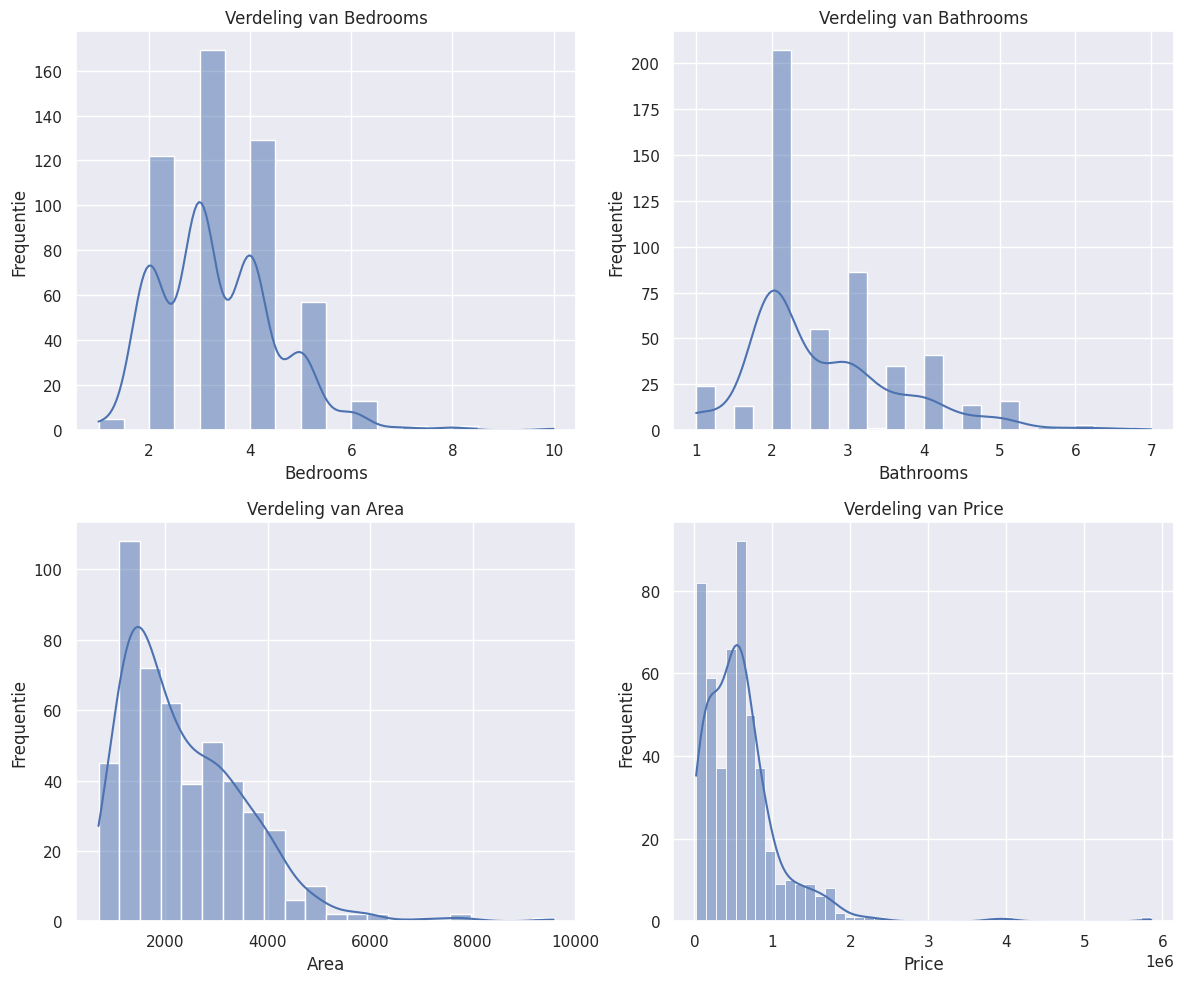

In [19]:
kolommen = ['Bedrooms', 'Bathrooms', 'Area', 'Price']

sns.set(style="darkgrid")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histogrammen plotten in het raster
ax_index = 0
for rij in range(2):
    for kolom in range(2):
        sns.histplot(train_numeriek_df[kolommen[ax_index]], kde=True, ax=axes[rij, kolom])
        axes[rij, kolom].set_title(f'Verdeling van {kolommen[ax_index]}')
        axes[rij, kolom].set_xlabel(kolommen[ax_index])
        axes[rij, kolom].set_ylabel('Frequentie')
        ax_index += 1

plt.tight_layout()  # Ruimte tussen subplots aanpassen
plt.show()

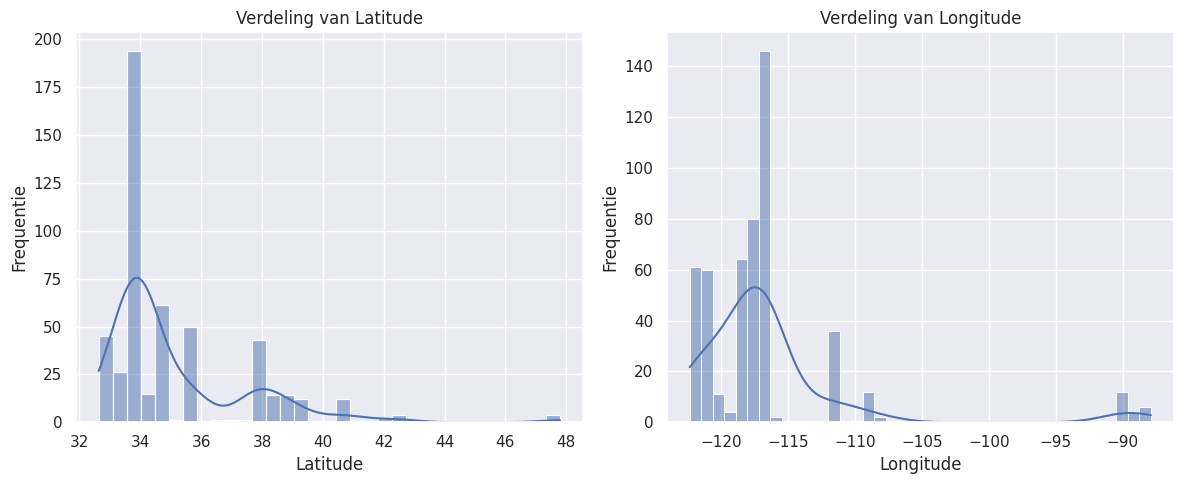

In [20]:
# Plot histogram voor longtitude en latitude
sns.set(style="darkgrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogrammen plotten in het raster
ax_index = 0
for kolom in ['Latitude', 'Longitude']:
    sns.histplot(train_numeriek_df[kolom], kde=True, ax=axes[ax_index])
    axes[ax_index].set_title(f'Verdeling van {kolom}')
    axes[ax_index].set_xlabel(kolom)
    axes[ax_index].set_ylabel('Frequentie')
    ax_index += 1

plt.tight_layout()
plt.show()

### Correlaties

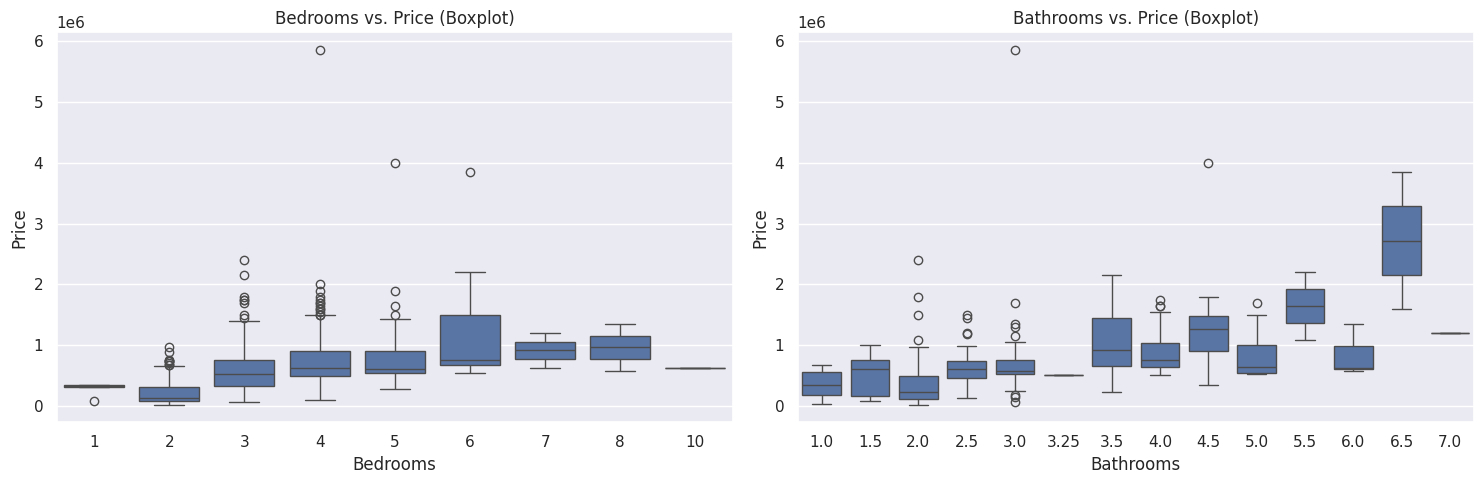

In [17]:
kolommen = ['Bedrooms', 'Bathrooms']

fig, axes = plt.subplots(1, len(kolommen), figsize=(15, 5))

# Boxplots plotten
for i, kolom in enumerate(kolommen):
    sns.boxplot(x=kolom, y='Price', data=train_numeriek_df, ax=axes[i])
    axes[i].set_title(f'{kolom} vs. Price (Boxplot)')
    axes[i].set_xlabel(kolom)
    axes[i].set_ylabel('Price')

plt.tight_layout()
plt.show()

#### Bevindingen

**Bedrooms**: Er zit geen sterke lineare verband in deze grafiek. Het blijkt dat huizen met slaapkamers van 1 tot 6 wel een lineare correlatie hebben, maar na 6 slaapkamers verschillen de prijzen niet meer.  
**Bathrooms**: Er blijkt geen lineare verband te zijn in deze grafiek. Maar er is wel te zien dat "halve" badkamers een hogere prijs hebben vergeleken met alleen complete badkamers.  

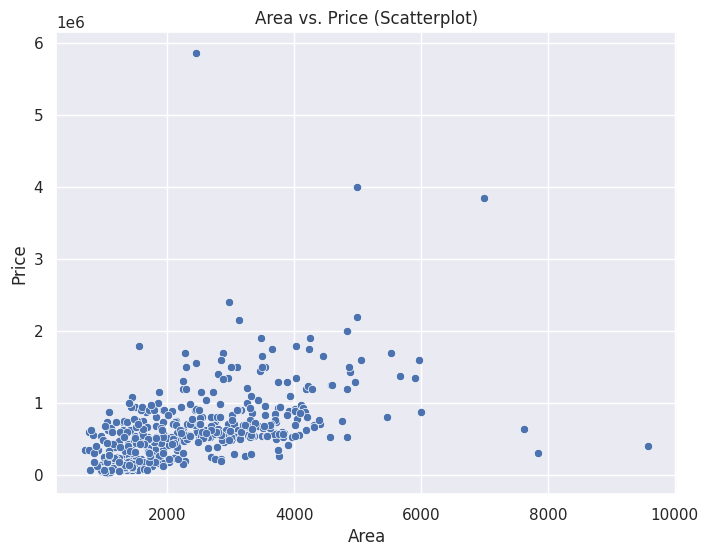

In [18]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Area', y='Price', data=train_numeriek_df)
plt.title('Area vs. Price (Scatterplot)')
plt.xlabel('Area')
plt.ylabel('Price')
plt.show()

**Area**: In deze grafiek is er wel een relatief linear verband. Het blijkt dat huizen met een grotere oppervlakte wel duurder zijn.

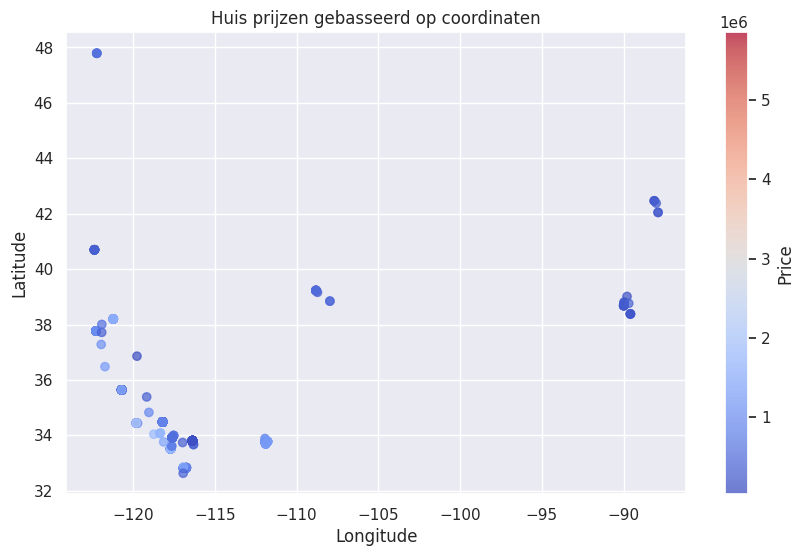

In [21]:
# Scatterplot maken
plt.figure(figsize=(10, 6))
scatter = plt.scatter(train_numeriek_df["Longitude"], train_numeriek_df["Latitude"], c=train_numeriek_df["Price"], cmap="coolwarm", alpha=0.7)

# Kleurbalk toevoegen
plt.colorbar(scatter, label="Price")

# Labels en titel
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Huis prijzen gebasseerd op coordinaten")

# Plot tonen
plt.show()

In deze grafiek worden de prijzen gevisualiseerd op basis van de coordinaten. Er blijkt dat er huizen helemaal links onder aan de duurdere kant liggen.

### Belangrijkste bevindingen
Over het algemeen lijkt woonoppervlakte de sterkste invloed te hebben op de huisprijs, terwijl het effect van slaapkamers en badkamers niet zo duidelijk is. Maar ook de locatie van de huizen blijken een invloed te hebben op de prijs

## Feature Engineering

### Data Preparation

In [22]:
import tensorflow as tf

def df_to_dataset(dataframe, labels, shuffle=True, batch_size=64):
    '''
    Function to convert a pandas DataFrame into a TensorFlow dataset
    Parameters:
        dataframe (pandas DataFrame): Input features to be converted
        labels (Pandas Series): Input labels to be converted
        shuffle (boolean): Whether to shuffle the dataframe
        batch_size (int): Batch size to use when training
    Returns:
        ds: TensorFlow dataset object
    '''
    df = dataframe.copy()
    df = {key: value.values[:,tf.newaxis] for key, value in dataframe.items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

### Splitting the data

In [23]:
X = train_numeriek_df.drop(['Price', 'House ID'], axis=1)
y = train_numeriek_df['Price']

# Get test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Get validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [24]:
train_ds = df_to_dataset(X_train, y_train, batch_size=32)
val_ds = df_to_dataset(X_val, y_val, shuffle=False, batch_size=32)
test_ds = df_to_dataset(X_test, y_test, shuffle=False, batch_size=32)

### Normalize layer

In [25]:
def get_normalization_layer(name, dataset):
    # Create a Normalization layer for the feature.
    normalizer = layers.Normalization(axis=None)

    # Prepare a Dataset that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data.
    normalizer.adapt(feature_ds)

    return normalizer

### Combinatie maken van de Latitude en Longitude
Latitude en Longitude hebben individueel geen relevante informatie. Maar als ze gecombineerd worden, dan kan het heel nuttige informatie geven. In de EDA werd er duidelijk gezien dat in een bepaald gebied de prijs wel duurder is. Dus vandaar dat de coordinaten ook relevant kunnen zijn.

In [29]:
def get_bucketization_layer(name, dataset, num_bins=10):
    # Create a Bucketization layer for the feature.
    bucketizer = layers.Discretization(num_bins=num_bins)

    # Prepare a Dataset that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data.
    bucketizer.adapt(feature_ds)

    return bucketizer

def get_feature_crossing_layer(feature1, feature2, num_bins=100):
    # Create HashedCrossing() layer
    cross = layers.HashedCrossing(num_bins=num_bins)

    # Cross the two features using this layer
    feature_cross = cross([feature1, feature2])

    #  Convert this tensor to the same type as the numeric tensors, float32 in this case. Use tf.cast()
    # feature_cross = layers.Lambda(lambda x: tf.cast(x, dtype=tf.float32))(feature_cross)

    return feature_cross

### Data Transforming

De tabulair data wordt eerst genormaliseerd met de boven gedefineerde functie. Daarna worden er bucket locations aangemaakt. Deze bucket locations representeren een bepaald area van de coordinaten. Alle inputs worden dan later samengevoegd

In [30]:
# Create a list to store the raw data inputs
all_inputs = []

# Create a list to store the bucketized latitude and longitude
bucketized_locations = []

# Create a list to store the engineered features
engineered_features = []

# Standardize numerical features
for header in ['Bedrooms', 'Bathrooms', 'Area']:

    # Create input layer with shape (1,) and name=header
    numeric_col = keras.Input(shape=(1,), name=header)

    # Call normalization function with the correct arguments
    normalization_layer = get_normalization_layer(name=header, dataset=train_ds)

    # Apply the layer on the input column
    encoded_numeric_col = normalization_layer(numeric_col)

    # Append input column to list of inputs
    all_inputs.append(numeric_col)

    # Append engineered feature to list of engineered features
    engineered_features.append(encoded_numeric_col)

# Bucketize location features
for header in ['Latitude', 'Longitude']:

    # Create input layer with shape (1,) and name=header
    location_col = keras.Input(shape=(1,), name=header)

    # Call bucketization function with the correct arguments
    bucketization_layer = get_bucketization_layer(name=header, dataset=train_ds, num_bins=2)

    # Apply the layer on the input column
    bucketized_col = bucketization_layer(location_col)

    # Append input column to list of inputs
    all_inputs.append(location_col)

    # Append engineered feature to list of bucketized locations
    bucketized_locations.append(bucketized_col)

# Cross the bucketized latitude with bucketized longitude
crossed_location_feature = get_feature_crossing_layer(bucketized_locations[0], bucketized_locations[1], num_bins=4)
engineered_features.append(crossed_location_feature)

# Merge the list of engineered features into one vector via concatentation with tf.keras.layers.concatenate
all_features = tf.keras.layers.concatenate(engineered_features)

In [ ]:
# Wijzig de vorm van alle afbeeldingen na de lus
resized_train_images = []
for image in train_images:
    resized_image = tf.image.resize(image, (224, 224))  # Wijzig de gewenste vorm
    resized_train_images.append(resized_image)

## Modeling

### Fully-connected neuraal netwerk

Een Fully Connected layer, ook bekend als een Dense layer, is een essentieel onderdeel van neurale netwerken. Elke neuron in een layer is verbonden met alle neuronen in de vorige en volgende laag, waardoor een sterk geïntegreerd netwerk ontstaat.

#### Structuur

Een fully connected layer bevat de volgende componenten:
- **Neuronen**: Basiseenheden die input ontvangen van alle neuronen in de vorige laag en output doorgeven aan de volgende laag.
- **Gewichten (Weights)**: Elk neuron heeft een gewicht dat bepaalt hoe sterk de input wordt beïnvloed.
- **Biases**: Een extra parameter die helpt de output te optimaliseren.
- **Activatiefuncties**: Niet-lineaire functies (zoals ReLU, Sigmoid of Tanh) worden toegepast om het netwerk complexe patronen te laten leren. Dit zorgt ervoor dat de uitkomst niet linear is

#### Werking
1. Input verwerking  
Elke neuron berekent een gewogen som van de inputs plus een bias:  
$$ z_j = \sum_{i} (w_{ij} \cdot x_i) + b_j $$

  Waarbij:  
    $w_{ij}$ = gewicht van neuron $i$ naar neuron $j$  
    $x_i$ = inputwaarde van neuron $i$  
    $b_j$ = bias van neuron $j$      


2. Toepassing van activatiefunctie  
Vervolgens wordt een activatiefunctie {f} toegepast, zoals ReLU, Sigmoid of Tanh:  
$$ a_j = f(z_j) $$

https://www.geeksforgeeks.org/what-is-fully-connected-layer-in-deep-learning/?ref=ml_lbp




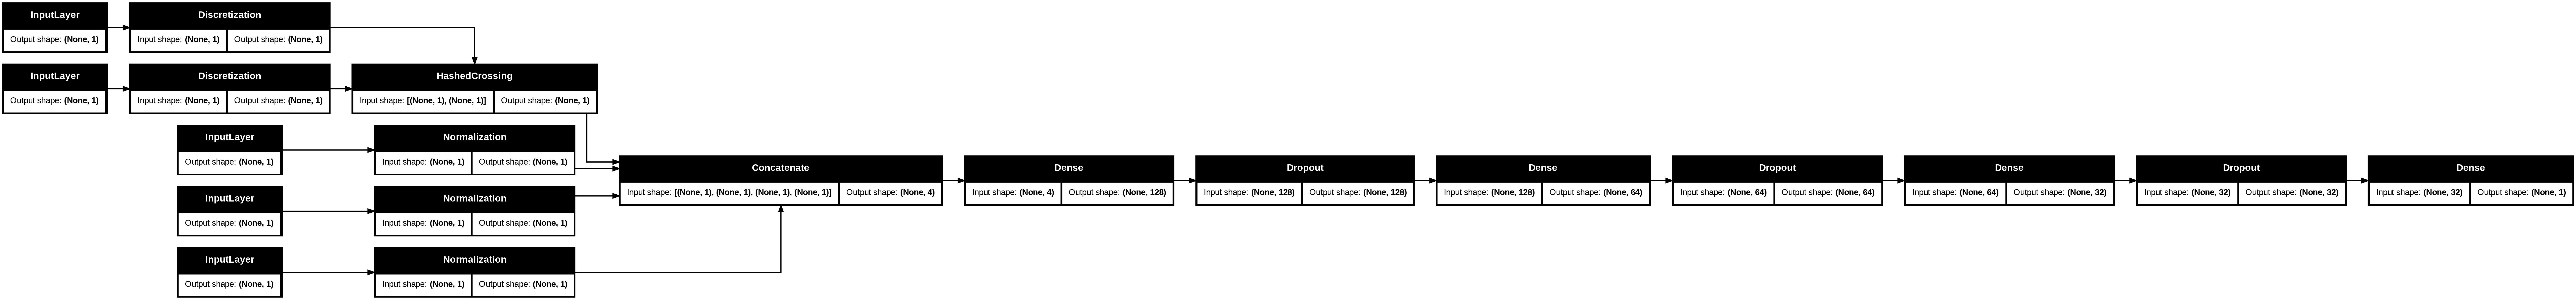

In [32]:
x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l1(0.01))(all_features)
x = layers.Dropout(0.2)(x)

x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)

output = layers.Dense(1)(x)

model_eng = Model(inputs=all_inputs, outputs=output)

model_eng.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mape', metrics=['mse','mape'])

plot_model(model_eng, show_shapes=True, rankdir="LR")

In [35]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model_eng.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1, epochs=150, callbacks=[early_stopping])

# Evaluate
loss, mse, mape = model_eng.evaluate(test_ds)
print("MSE: ", mse)
print("MAPE: ", mape)

Epoch 1/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 100.4606 - mape: 99.9995 - mse: 508791095296.0000 - val_loss: 100.2608 - val_mape: 99.9972 - val_mse: 1329773150208.0000
Epoch 2/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 100.2121 - mape: 99.9950 - mse: 517117575168.0000 - val_loss: 100.0791 - val_mape: 99.9811 - val_mse: 1329714167808.0000
Epoch 3/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 100.0443 - mape: 99.9687 - mse: 511802802176.0000 - val_loss: 99.9247 - val_mape: 99.8961 - val_mse: 1329408770048.0000
Epoch 4/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 99.8769 - mape: 99.8505 - mse: 548513054720.0000 - val_loss: 99.5892 - val_mape: 99.5630 - val_mse: 1328232005632.0000
Epoch 5/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 99.4464 - mape: 99.4150 - mse: 612188028928.0000 - val_loss: 98.5456 - val_mape: 98.4689 - val_mse: 1324465258496.0000
Epoch 6/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 98.1166 - mape: 98.0034 - mse: 564316471296.

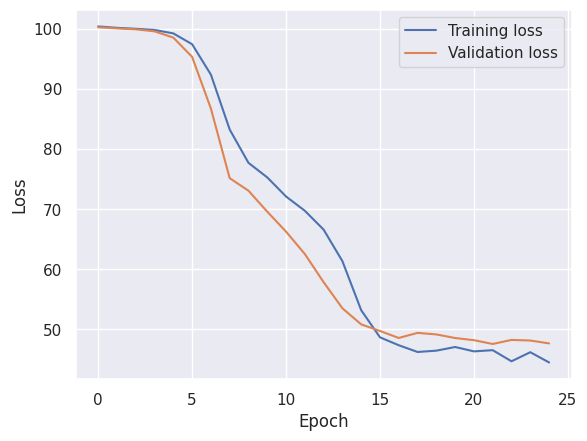

In [36]:
# Plot de loss curves
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Convolutioneel neuraal netwerk from scratch

Een Convolutioneel Neuraal Netwerk (CNN) is een speciaal type neuraal netwerk dat vooral wordt gebruikt voor het verwerken van afbeeldingen. CNN's zijn goed in taken zoals het herkennen van objecten en het classificeren van beelden. Ze werken door patronen in een afbeelding te zoeken met behulp van wiskundige berekeningen, zoals convoluties. Hierdoor kunnen ze vormen, randen en structuren herkennen, wat belangrijk is voor computer vision-toepassingen zoals gezichtsherkenning en zelfrijdende auto's.

[(Torres, 2023)](https://medium.com/latinxinai/convolutional-neural-network-from-scratch-6b1c856e1c07)


#### Basisprincipes van CNN's


##### 1. Convolutie Laag (Convolution Layer)


De convolutielaag is een belangrijk onderdeel van een CNN. Het gebruikt een klein filter (ook wel kernel genoemd) om een afbeelding te analyseren en belangrijke kenmerken te herkennen.

- Filter: Een klein raster (bijvoorbeeld 3×3) dat over de afbeelding beweegt.

- Stapgrootte (Stride): Het aantal pixels dat het filter per keer opschuift.

- Padding: Extra pixels aan de randen van de afbeelding toevoegen om de afmetingen van de uitvoer te behouden.

[(Torres, 2023)](https://medium.com/latinxinai/convolutional-neural-network-from-scratch-6b1c856e1c07)

[(GeeksforGeeks, 2024b)](https://www.geeksforgeeks.org/introduction-convolution-neural-network/
)


**Berekening:** Op elke positie wordt het filter vermenigvuldigd met het bijbehorende deel van de afbeelding. Daarna worden de resultaten opgeteld om een nieuw beeld te vormen.

##### 2. Pooling Laag (Pooling Layer)

Pooling is een techniek die helpt om de hoeveelheid gegevens in een afbeelding te verkleinen. Dit maakt het model sneller en minder gevoelig voor kleine veranderingen in de afbeelding.

- Max Pooling: Kiest de hoogste waarde in een klein gebied van de afbeelding.

- Average Pooling: Berekent het gemiddelde van de waarden in een klein gebied.

[(Torres, 2023)](https://medium.com/latinxinai/convolutional-neural-network-from-scratch-6b1c856e1c07)

##### 3. Activatiefunctie (Activation Function)

Een activatiefunctie zorgt ervoor dat een neuraal netwerk complexe patronen kan leren door niet-lineariteit toe te voegen. Een veelgebruikte activatiefunctie is ReLU (Rectified Linear Unit), die negatieve waarden naar nul omzet en positieve waarden doorlaat.


[(GeeksforGeeks, 2024b)](https://www.geeksforgeeks.org/introduction-convolution-neural-network/)


##### 4. Fully Connected Layer (Volledig verbonden laag)

Deze laag zorgt voor de classificatie op basis van de kenmerken die in de vorige lagen zijn gevonden. Terwijl convolutie- en poolinglagen vaak de ReLU-activeringsfunctie gebruiken, maakt de volledig verbonden laag (fully connected layer) gebruik van de Softmax-functie. Deze functie zet de uitkomsten om in waarschijnlijkheden tussen 0 en 1, zodat het netwerk kan voorspellen tot welke klasse een invoer behoort.


[(Torres, 2023)](https://medium.com/latinxinai/convolutional-neural-network-from-scratch-6b1c856e1c07)


[(IBM. (z.d.))](https://www.ibm.com/think/topics/convolutional-neural-networks)

#### Regularisatie in Convolutionele Neurale Netwerken


**L1-regularisatie (Lasso):** Hierbij wordt de absolute waarde van de gewichten opgeteld bij de verliesfunctie. Dit zorgt ervoor dat sommige gewichten precies nul worden, waardoor minder belangrijke parameters verdwijnen. Het resultaat is een eenvoudiger model met minder filters.

$$
\text{Loss} = \text{lossfunctie} + \lambda \sum |β_i|
$$

**L2-regularisatie (Ridge, Weight Decay):** Deze methode telt de kwadraten van de gewichten op bij de verliesfunctie. Hierdoor blijven de gewichten klein en worden extreme waarden voorkomen. Dit helpt het model stabieler en minder gevoelig voor overfitting te maken.

$$
\text{Loss} = \text{lossfunctie} + \lambda \sum β_i^2
$$


[(Tewari, 2024)](https://medium.com/analytics-vidhya/regularization-understanding-l1-and-l2-regularization-for-deep-learning-a7b9e4a409bf)



**Dropout** is een techniek om overfitting te voorkomen in diepe neurale netwerken. Tijdens het trainen worden willekeurig sommige uitgangen van een laag genegeerd ("dropout"). Hierdoor leert het model minder afhankelijk te zijn van specifieke neuronen en wordt het robuuster.

[(GeeksforGeeks, 2024a)](https://www.geeksforgeeks.org/dropout-regularization-in-deep-learning/
)


Batch normalisatie zorgt ervoor dat een CNN sneller en stabieler traint door de activaties per batch te normaliseren. Dit voorkomt dat waarden te groot of te klein worden en helpt het netwerk beter om te gaan met variaties in de invoerdata. Hierdoor kan het model efficiënter leren.



[(Wikipedia contributors, 2024b)](https://en.wikipedia.org/wiki/Batch_normalization#:~:text=December%202021),and%20Christian%20Szegedy%20in%202015.)

Data-augmentatie is een manier om overfitting te verminderen bij CNN’s. Door de trainingsdata te variëren met technieken zoals roteren, schalen, spiegelen en vervormen, leert het model robuustere en algemenere kenmerken. Dit helpt het netwerk beter om te gaan met nieuwe, onbekende afbeeldingen.

[(IBM. (z.d.))](https://www.ibm.com/think/topics/data-augmentation)


#### Hoe kies je de beste regularisatie?

De keuze voor regularisatie hangt af van het doel van je model. L1-regularisatie is handig als je een eenvoudiger model met minder parameters wilt, terwijl L2-regularisatie beter is als je alle features wilt behouden maar hun invloed wilt beperken. Data-augmentatie is vooral nuttig bij beeldherkenning en deep learning, omdat het variatie in de trainingsdata toevoegt en zo de generalisatie verbetert. Dropout werkt goed in diepe neurale netwerken, vooral bij grote modellen, omdat het willekeurig neuronen uitschakelt tijdens training en zo overfitting tegengaat.

[(Olamendy, 2024)](https://medium.com/@juanc.olamendy/a-comprehensive-guide-to-regularization-in-machine-learning-9d1243002c50)

Een kolom 'filename' wordt toegevoegd aan de DataFrame train_numeriek_df, waarin het bestandspad van elke afbeelding wordt gegenereerd op basis van de 'House ID'.

In [ ]:
# Genereert een nieuwe kolom 'filename'
train_numeriek_df['filename'] = train_numeriek_df['House ID'].apply(lambda x: f"{img_train_directory}/{x}.jpg")

# Controleer of de bestanden bestaan
invalid_files = []
for file_path in train_numeriek_df['filename']:
    if not os.path.exists(file_path):
        invalid_files.append(file_path)

if invalid_files:
    print(f"Aantal ongeldige bestanden: {len(invalid_files)}")
    print("Voorbeelden van ongeldige bestanden:", invalid_files[:5])
else:
    print("Alle bestanden zijn geldig.")


Alle bestanden zijn geldig.


De dataset train_numeriek_df wordt opgesplitst in een trainingset (80%) en een validatieset (20%), waarbij random_state=42 zorgt voor reproduceerbaarheid.

In [ ]:
# Split in train/validation
train_df = train_numeriek_df.sample(frac=0.8, random_state=42)
val_df = train_numeriek_df.drop(train_df.index)


De prijzen in zowel de trainings- als validatieset worden genormaliseerd door elke waarde te delen door de maximale prijs in de dataset.

In [ ]:
train_df['Price'] = train_df['Price'] / train_df['Price'].max()
val_df['Price'] = val_df['Price'] / val_df['Price'].max()

Een data-augmentatiepipeline wordt ingesteld voor de trainingsset, waarbij afbeeldingen worden geschaald en willekeurig getransformeerd. De validatieset wordt alleen geschaald. Vervolgens worden generators aangemaakt om de afbeeldingen en bijbehorende prijzen in batches te laden voor modeltraining.

In [ ]:
# Data augmentation voor training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    zoom_range=0.2
)

# Alleen rescaling voor validatie
val_datagen = ImageDataGenerator(rescale=1./255)


# Train generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='Price',
    target_size=(256, 256),
    class_mode='raw',
    batch_size=32,
    shuffle=True  # ✅ Zorg dat de batches worden geschud
)

# Validation generator
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='Price',
    target_size=(256, 256),
    class_mode='raw',
    batch_size=32,
    shuffle=False  #
)


Found 400 validated image filenames.
Found 100 validated image filenames.


In [ ]:
# Definieer het CNN-model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),  # Dropout voor regularisatie
    Dense(1)  # Output laag voor regressie
])

# Compileer het model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_squared_error',  # Gebruik MSE voor regressie
              metrics=['mae'])  # Mean Absolute Error als metriek

# Early Stopping om overfitting te voorkomen
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Samenvatting van het model
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │      25,690,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,079,553 (99.49 MB)

 Trainable params: 26,079,553 (99.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train het model
history = model.fit(
    train_generator,
    epochs=10,  # Aantal epochs, kan aangepast worden
    validation_data=validation_generator,
    callbacks=[early_stopping],  # Gebruik EarlyStopping om overfitting te voorkomen
    verbose=1
)

# Evalueer het model op de validatiedata
loss, mae = model.evaluate(validation_generator)
print(f"Validation Loss (MSE): {loss}")
print(f"Validation MAE: {mae}")

# Voorspel de waarden voor de validatiedata
y_pred = model.predict(validation_generator)
y_true = validation_generator.labels

# Bereken MAPE handmatig
mape = np.mean(np.abs((y_true - y_pred.flatten()) / y_true)) * 100
print(f"Validation MAPE: {mape:.2f}%")

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 109s 8s/step - loss: 0.4723 - mae: 0.0617 - val_loss: 0.5163 - val_mae: 0.1988
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 107s 8s/step - loss: 0.4474 - mae: 0.0664 - val_loss: 0.4860 - val_mae: 0.1846
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 105s 8s/step - loss: 0.4261 - mae: 0.0661 - val_loss: 0.4812 - val_mae: 0.2094
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 137s 8s/step - loss: 0.4073 - mae: 0.0613 - val_loss: 0.4480 - val_mae: 0.1802
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 95s 7s/step - loss: 0.3908 - mae: 0.0662 - val_loss: 0.4406 - val_mae: 0.1929
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 147s 8s/step - loss: 0.3752 - mae: 0.0636 - val_loss: 0.4228 - val_mae: 0.1847
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 140s 7s/step - loss: 0.3646 - mae: 0.0652 - val_loss: 0.4145 - val_mae: 0.1914
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 95s 7s/step - loss: 0.3523 - mae: 0.0634 - val_loss: 0.4029 - val_mae: 0.1907
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 98s 7s/step - loss: 0.3414 -

### Transfer learning

### Multimodaal mode

## Results

### Overview

### Scores

## Conclusion & Advice

In [ ]:
# test_numeriek_df

In [ ]:
import numpy as np
import pandas as pd

def submission(pred, test_df, filename):
    """
    Creates a submission file for a prediction.

    Args:
        pred (np.ndarray): The predictions.
        test_df (pd.DataFrame): The test dataframe.
        filename (str): The filename of the submission file (must include .csv extension).

    Returns:
        pd.DataFrame: The submission dataframe.
    """
    # Ensure pred is a 1D array and has the same length as test_df
    pred = pred.reshape(-1)  # Flatten if necessary
    pred = pred[:len(test_df)]  # Truncate to match test_df length

    # Create the submission DataFrame
    df = pd.DataFrame({'House ID': test_df['House ID'], 'Price': pred})

    # Save the DataFrame to a CSV file
    df_n = df.to_csv(filename, index=False)

    # Return the DataFrame (optional)
    return df_n

In [ ]:
submission(y_pred, test_numeriek_df, 'CNN5.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Sources

- Torres, L. F. (2023, 23 november). Convolutional Neural Network From Scratch - LatinXInAI - Medium. Medium. https://medium.com/latinxinai/convolutional-neural-network-from-scratch-6b1c856e1c07

- GeeksforGeeks. (2024b, oktober 10). Introduction to Convolution Neural Network. GeeksforGeeks. https://www.geeksforgeeks.org/introduction-convolution-neural-network/

- IBM. (z.d.). Convolutional neural networks. IBM. https://www.ibm.com/think/topics/convolutional-neural-networks

- Tewari, U. (2024, 19 januari). Regularization — Understanding L1 and L2 regularization for Deep Learning. Medium. https://medium.com/analytics-vidhya/regularization-understanding-l1-and-l2-regularization-for-deep-learning-a7b9e4a409bf

- GeeksforGeeks. (2024a, maart 26). Dropout regularization in deep learning. GeeksforGeeks. https://www.geeksforgeeks.org/dropout-regularization-in-deep-learning/

- Wikipedia contributors. (2024b, december 25). Batch normalization. Wikipedia. https://en.wikipedia.org/wiki/Batch_normalization#:~:text=December%202021),and%20Christian%20Szegedy%20in%202015.

- Olamendy, J. C. (2024, 28 november). A Comprehensive Guide to Regularization in Machine Learning. Medium. https://medium.com/@juanc.olamendy/a-comprehensive-guide-to-regularization-in-machine-learning-9d1243002c50

- IBM. (z.d.). Data augmentation. https://www.ibm.com/think/topics/data-augmentation